In [ ]:
# Conexión a Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# Descomprimir el dataset

!unzip gdrive/MyDrive/DatasetMedidor/positions_cal.zip

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
# Obtener los datos y guardarlos en variables con las que se pueda trabajar

img_height, img_width = 224,224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "positions_cal/train",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "positions_cal/validation",
    seed=123,
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE
)

#test_ds = tf.keras.utils.image_dataset_from_directory(
#    "positions/test",
#    subset="testing",
#    image_size = (img_height, img_width)
#    ,batch_size = BATCH_SIZE
#)



In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [12]:
# Imprimir las clases existentes del dataset

class_names = train_ds.class_names
print(class_names)

['0', '0.5', '1', '1.5', '2', '2.5', '3', '3.5', '4', '4.5', '5', '5.5', '6', '6.5', '7', '7.5', '8', '8.5', '9', '9.5']


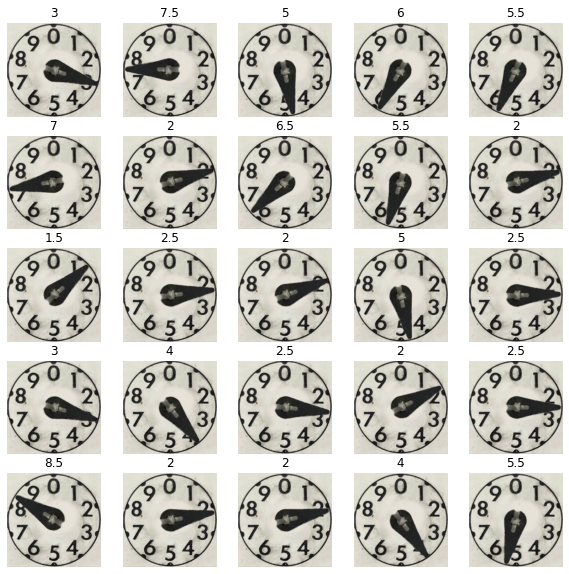

In [13]:
# Mostrar los datos con sus respectivas etiquetas

plt.figure(figsize= (10,10))

for i, (images, labels) in enumerate(train_ds.take(25)):
  plt.subplot(5, 5, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]])
  plt.axis("off")

In [ ]:
# Red Neuronal

model = tf.keras.Sequential ([
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),

     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(20)                              
])

In [ ]:
# Compilador, esto es para obtener una presición de los datos
# en base al dato de entrada en la red neuronal.
model.compile (
    optimizer = "adam",
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits= True),
    metrics = ['accuracy']
)

In [ ]:
# Entrenamiento

EPOCHS = 100;
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE
)

In [ ]:
# Exportar el entrenamiento a un modelo que se pueda trabajar en Android Studio
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Gráficas del entrenamiento y precisión de la red neuronal

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()